In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# p : X -> [0,1]
# Sigmoid function is monotonic
def p(x) -> float:
    return 1 / (1 + np.exp(-x))

def expected(x, plus, minus):
    return p(x) * plus + (1-p(x)) * minus

def opt_step(X, u_plus, u_minus, c_plus, c_minus):
    max_util = [x + expected(x, c_plus, c_minus) if expected(x, u_plus, u_minus) > 0 else x for x in X]
    thresholds = [x for x in X if expected(x, u_plus, u_minus) > 0]
    opt_thresh = min(thresholds) if thresholds else None
    return (max_util, opt_thresh)

def fair_opt_step(A, B, u_plus, u_minus, c_plus, c_minus, alpha):
    a_threshholds = np.sort(A)
    b_threshholds = np.sort(B)
    max_util =  -np.inf
    opt_a, opt_b = None, None
    updated_samples = None
    np.random.seed(1)
    prob = 0.4

    w_a = len(A) / (len(A) + len(B))
    w_b = len(B) / (len(A) + len(B))

    for i in a_threshholds:
        a = []
        for sample in A:
            w = sample + expected(sample, c_plus, c_minus)
            if w < i:
                a.append(sample)
            elif w == i:
                if np.random.rand() < prob:
                    a.append(w)
                else:
                    a.append(sample)
            else:
                a.append(w)

        for j in b_threshholds:
            b = []
            for sample in B:
                w = sample + expected(sample, c_plus, c_minus)
                if w < j:
                    b.append(sample)
                elif sample == j:
                    if np.random.rand() < prob:
                       b.append(w) 
                    else:
                        b.append(sample)
                else:
                    b.append(w)

            if (np.abs(np.mean(a) - np.mean(b))) <= alpha:
                util = w_a * expected(np.mean(a), u_plus, u_minus) + w_b * expected(np.mean(b), u_plus, u_minus)
                max_util = max(max_util, util)
                if max_util == util:
                    opt_a, opt_b = i, j
                    updated_samples = (a,b)
            else:
                continue
    return (opt_a, opt_b, max_util, updated_samples)

[np.float64(0.9872422901701187), np.float64(1.082480385408214), np.float64(1.225337528265357), np.float64(1.320575623503452), np.float64(1.320575623503452), np.float64(1.320575623503452), np.float64(1.320575623503452), np.float64(1.320575623503452), np.float64(1.320575623503452), np.float64(1.320575623503452)]


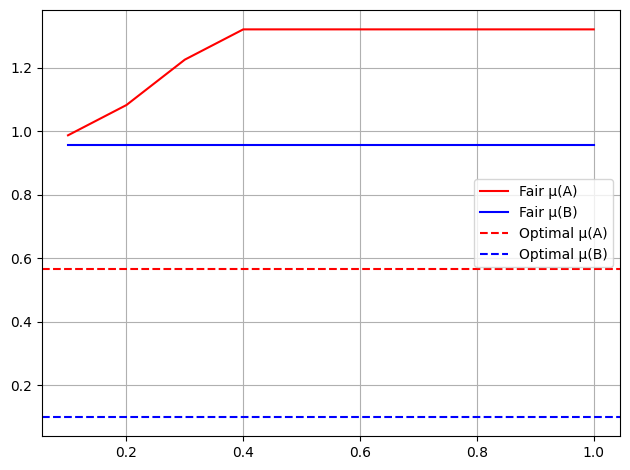

In [ ]:
## Plotting Fair and Optimal Means
n_samples = 21
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1
x_min, x_max = -1, 1

np.random.seed(1)
A = np.random.normal(mean_a, std_a, n_samples)
B = np.random.normal(mean_b, std_b, n_samples)

x = np.linspace(x_min, x_max, num=n_samples)

x1 = []
y1 = []
y2 = []
y3 = np.mean(opt_step(A, 1, -1, 1, -1)[0])
y4 = np.mean(opt_step(B, 1, -1, 1, -1)[0])

for i in x:
    results = fair_opt_step(A, B, 1, -1, 1, 1, alpha=i)[3]
    if results is not None:
        x1.append(i)
        y1.append(np.mean(results[0]))
        y2.append(np.mean(results[1]))
    else:
        continue

print(y1)
plt.plot(x1, y1, label="Fair μ(A)", color='red')
plt.plot(x1, y2, label="Fair μ(B)", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)')

plt.title("Fair and Optimal Means")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.tight_layout()


[np.float64(0.8190390960570986), np.float64(0.5422137467155929), np.float64(0.32757179244956425), np.float64(-1.560140709497654), np.float64(-1.560140709497654), np.float64(-1.560140709497654), np.float64(-1.560140709497654), np.float64(-1.560140709497654), np.float64(-1.560140709497654), np.float64(-1.560140709497654)]


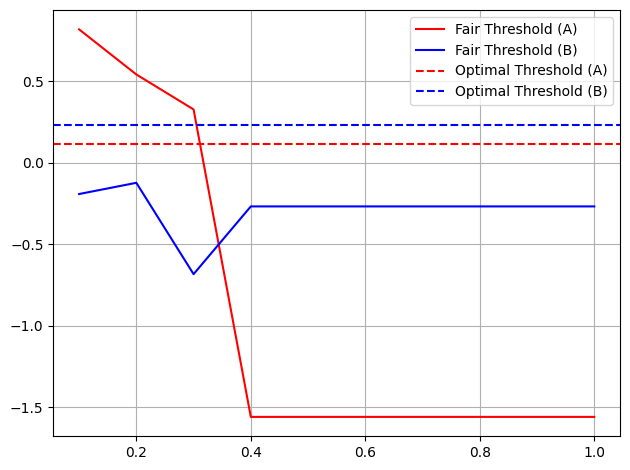

In [ ]:
### Plotting the Fair Thresholds and Optimal Thresholds

n_samples = 21
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1
x_min, x_max = -1, 1

np.random.seed(1)
A = np.random.normal(mean_a, std_a, n_samples)
B = np.random.normal(mean_b, std_b, n_samples)

x = np.linspace(x_min, x_max, num=n_samples)

x1 = []
y1 = []
y2 = []
y3 = opt_step(A, 1, -1, 1, -1)[1]
y4 = opt_step(B, 1, -1, 1, -1)[1]

for i in x:
    results = fair_opt_step(A, B, 1, -1, 1, 1, alpha=i)
    if results[0] is not None and results[1] is not None:
        x1.append(i)
        y1.append(results[0])
        y2.append(results[1])
    else:
        continue

print(y1)
plt.plot(x1, y1, label="Fair Threshold (A)", color='red')
plt.plot(x1, y2, label="Fair Threshold (B)", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal Threshold (A)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal Threshold (B)')

plt.title("Fair and Optimal Thresholds")
plt.xlabel("Alpha (α)")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
